
--- Özet ---
                  Yöntem  x1(Ts)  x2(Th)     x3(R)      x4(L)  En iyi maliyet        g1        g2            g3          g4  Süre (s)
Jaya + Chebyshev (Ykş.2)     1.0     1.0 48.069427 114.485341     8849.990902 -0.072260 -0.541418   -329.764599 -125.514659  0.014043
   Jaya + Circle (Ykş.1)     1.0     1.0 46.348205 130.258512     8909.179614 -0.105480 -0.557838   -115.982875 -109.741488  0.020331
   Jaya + Arnold (Ykş.2)     1.0     1.0 47.846518 122.786213     9065.146946 -0.076562 -0.543544 -45897.358822 -117.213787  0.020866
         Jaya (Orijinal)     1.0     1.0 49.045872 115.303925     9135.134129 -0.053415 -0.532102 -69554.872669 -124.696075  0.024268
Jaya + Bernoulli (Ykş.2)     1.0     1.0 42.087881 177.135344     9185.708269 -0.187704 -0.598482  -2046.763791  -62.864656  0.017878
   Jaya + Arnold (Ykş.1)     1.0     1.0 45.644317 147.803128     9276.985166 -0.119065 -0.564553 -69737.107290  -92.196872  0.021635

Kaydedilen dosyalar:
 - basincli_kap_jaya_chaos

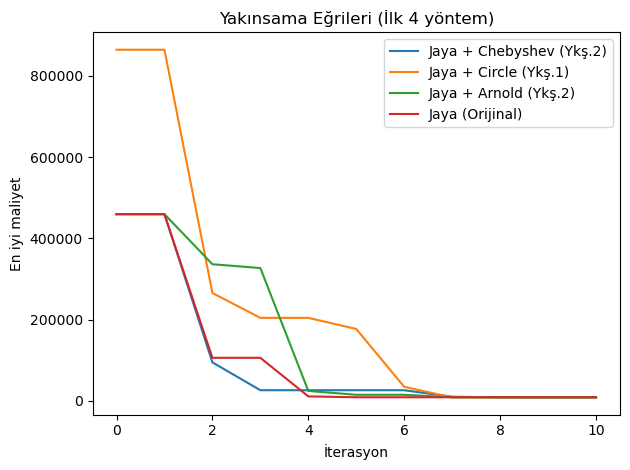

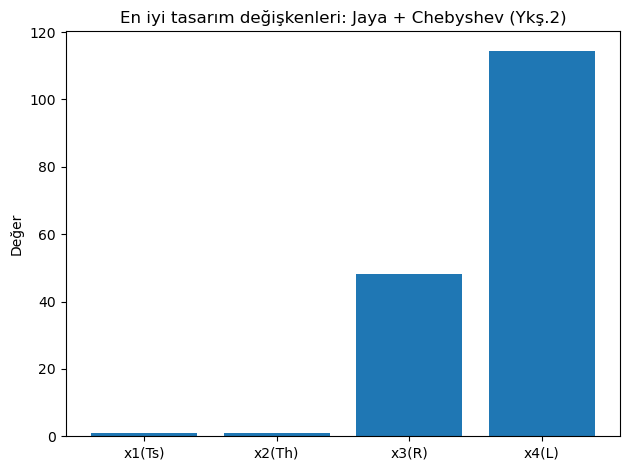

In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

# -----------------------------
# Pressure Vessel Design Problem
# Standard single-objective constrained optimization
# -----------------------------

# Constants
# x1 = Ts (shell thickness)
# x2 = Th (head thickness)
# x3 = R  (inner radius)
# x4 = L  (cylindrical section length without heads)
lb = np.array([1.0, 1.0, 10.0, 10.0], dtype=float)
ub = np.array([99.0, 99.0, 200.0, 200.0], dtype=float)

def pressure_vessel_cost(x):
    Ts, Th, R, L = x
    return 0.6224 * Ts * R * L + 1.7781 * Th * R**2 + 3.1661 * Ts**2 * L + 19.84 * Ts**2 * R

def pressure_vessel_constraints_raw(x):
    Ts, Th, R, L = x
    g1 = -Ts + 0.0193 * R  # <= 0 → Ts ≥ 0.0193R
    g2 = -Th + 0.00954 * R # <= 0 → Th ≥ 0.00954R
    g3 = -math.pi * R**2 * L - (4/3)*math.pi * R**3 + 1296000.0  # <= 0 → volume ≥ 1296000 in^3
    g4 = L - 240.0  # <= 0 → L ≤ 240
    return [g1, g2, g3, g4]

def fitness(x, penalty_coef=1e7):
    c = pressure_vessel_cost(x)
    g = pressure_vessel_constraints_raw(x)
    viol = [max(0.0, gi) for gi in g]
    return c + penalty_coef * sum(v*v for v in viol)

# -----------------------------
# Chaotic Maps (same as beam problem)
# -----------------------------
def bernoulli_shift(x, lam=0.7):
    return x/lam if x < lam else (x - lam)/(1.0 - lam)

def chebyshev_map(x, f=4):
    y = 2.0*x - 1.0
    y_next = math.cos(f*math.acos(max(-1.0, min(1.0, y))))
    return (y_next + 1.0)/2.0

def circle_map(x, a=0.5, k=0.2):
    return (x + a - (k/(2.0*math.pi))*math.sin(2.0*math.pi*x)) % 1.0

def cubic_map(x, r=2.59):
    xn = r*x*(1.0 - x*x)
    if xn <= 0.0 or xn >= 1.0 or math.isnan(xn):
        xn = (abs(xn) % 1.0) or 0.5
    return xn

def arnold_cat_map(xy):
    x, y = xy
    return (x + y) % 1.0, (x + 2.0*y) % 1.0

def chaotic_sequence(length, method="bernoulli", seed=0.12345):
    seq = []
    if method == "arnold":
        x, y = ((seed*7.123) % 1.0, (seed*3.789) % 1.0)
        for _ in range(length):
            x, y = arnold_cat_map((x, y))
            seq.append(x); seq.append(y)
        seq = seq[:length]
    else:
        x = (seed*1.234567) % 1.0
        if x <= 0.0: x = 0.123456
        for _ in range(length):
            if method == "bernoulli":
                x = bernoulli_shift(x)
            elif method == "chebyshev":
                x = chebyshev_map(x)
            elif method == "circle":
                x = circle_map(x)
            elif method == "cubic":
                x = cubic_map(x)
            else:
                x = (x*9301 + 49297) % 233280 / 233280.0
            x = min(1.0 - 1e-12, max(1e-12, x))
            seq.append(x)
    return np.array(seq)

# -----------------------------
# Jaya Algorithm
# -----------------------------
def jaya(pop_size=30, max_iter=500, approach="baseline", chaotic="none", seed=42):
    rng = np.random.default_rng(seed)
    D = 4
    N = pop_size

    # Initialization
    if approach == "chaos_init" and chaotic != "none":
        seq = chaotic_sequence(N*D, method=chaotic, seed=seed/100.0 + 0.13579)
        seq = seq.reshape(N, D)
        pop = lb + seq*(ub - lb)
    else:
        pop = lb + rng.uniform(size=(N, D))*(ub - lb)

    fit = np.array([fitness(ind) for ind in pop])
    best_idx = int(np.argmin(fit))
    best = pop[best_idx].copy()
    best_fit = fit[best_idx]
    history = [best_fit]

    # Chaotic sequence for iteration updates
    if approach == "chaos_iter" and chaotic != "none":
        seq_len = max_iter*N*D*2
        cseq = chaotic_sequence(seq_len, method=chaotic, seed=seed/10.0 + 0.2468)
        cptr = 0
    else:
        cseq, cptr = None, 0

    for it in range(max_iter):
        worst_idx = int(np.argmax(fit))
        worst = pop[worst_idx]
        new_pop = pop.copy()
        for i in range(N):
            r1 = rng.uniform(size=D)
            r2 = rng.uniform(size=D)
            if approach == "chaos_iter" and chaotic != "none":
                r1 = cseq[cptr:cptr+D]; cptr += D
                r2 = cseq[cptr:cptr+D]; cptr += D
            candidate = pop[i] + r1*(best - abs(pop[i])) - r2*(worst - abs(pop[i]))
            candidate = np.minimum(ub, np.maximum(lb, candidate))
            f_new = fitness(candidate)
            if f_new < fit[i]:
                new_pop[i] = candidate
                fit[i] = f_new
                if f_new < best_fit:
                    best_fit = f_new
                    best = candidate.copy()
        pop = new_pop
        history.append(best_fit)
    return best, best_fit, np.array(history)

# -----------------------------
# Run Experiments
# -----------------------------
def run_experiments():
    methods = [
        ("baseline", "none",       "Jaya (Orijinal)"),
        ("chaos_init", "arnold",   "Jaya + Arnold (Ykş.1)"),
        ("chaos_init", "bernoulli","Jaya + Bernoulli (Ykş.1)"),
        ("chaos_init", "chebyshev","Jaya + Chebyshev (Ykş.1)"),
        ("chaos_init", "circle",   "Jaya + Circle (Ykş.1)"),
        ("chaos_init", "cubic",    "Jaya + Cubic (Ykş.1)"),
        ("chaos_iter", "arnold",   "Jaya + Arnold (Ykş.2)"),
        ("chaos_iter", "bernoulli","Jaya + Bernoulli (Ykş.2)"),
        ("chaos_iter", "chebyshev","Jaya + Chebyshev (Ykş.2)"),
        ("chaos_iter", "circle",   "Jaya + Circle (Ykş.2)"),
        ("chaos_iter", "cubic",    "Jaya + Cubic (Ykş.2)"),
    ]

    results = []
    histories = {}

    # ---- ITERATION COUNT ----
    # Buradan değiştirebilirsin (örnek: 100, 500, 1000)
    max_iter = 10

    for appr, cmap, label in methods:
        start_time = time.time()
        best, bestfit, hist = jaya(pop_size=40, max_iter=max_iter, approach=appr, chaotic=cmap, seed=123)
        runtime = time.time() - start_time
        g = pressure_vessel_constraints_raw(best)
        results.append({
            "Yöntem": label,
            "x1(Ts)": best[0],
            "x2(Th)": best[1],
            "x3(R)": best[2],
            "x4(L)": best[3],
            "En iyi maliyet": bestfit,
            "g1": g[0], "g2": g[1], "g3": g[2], "g4": g[3],
            "Süre (s)": runtime
        })
        histories[label] = hist

    df = pd.DataFrame(results).sort_values("En iyi maliyet").reset_index(drop=True)

    # Save CSV
    csv_path = "basincli_kap_jaya_chaos_results.csv"
    df.to_csv(csv_path, index=False)

    # Plot convergence
    top_labels = list(df["Yöntem"].head(4).values)
    plt.figure()
    for lbl in top_labels:
        plt.plot(histories[lbl], label=lbl)
    plt.xlabel("İterasyon")
    plt.ylabel("En iyi maliyet")
    plt.title("Yakınsama Eğrileri (İlk 4 yöntem)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("kap_yakin_sama_egri.png", dpi=160)

    # Bar of best variables
    best_label = df.iloc[0]["Yöntem"]
    bx = df.iloc[0][["x1(Ts)", "x2(Th)", "x3(R)", "x4(L)"]].values
    plt.figure()
    plt.bar(["x1(Ts)", "x2(Th)", "x3(R)", "x4(L)"], bx)
    plt.ylabel("Değer")
    plt.title(f"En iyi tasarım değişkenleri: {best_label}")
    plt.tight_layout()
    plt.savefig("kap_en_iyi_tasarim_deg.png", dpi=160)

    print("\n--- Özet ---")
    print(df.head(6).to_string(index=False))
    print("\nKaydedilen dosyalar:")
    print(" -", csv_path)
    print(" - kap_yakin_sama_egri.png")
    print(" - kap_en_iyi_tasarim_deg.png")
    return df

if __name__ == "__main__":
    run_experiments()
